In [12]:
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn ta gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 1.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827729 sha256=5ef3aca6e001f6e5daa1cb068ae8154cdd9e3f37ad50ef390f1705e8ee5d609a
  Stored in directory: /home/tharun3086/.cache/pip/wheels/95/51/6c/9bb05ebbe7c5cb8171dfaa3611f32622ca4658d53f31c79077
Successfully built gym
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gym]2/3 [gym]


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import ta

In [7]:
tickers = ["GOOG", "BTC-USD"]  # Indian stock (reliance) and cryptocurrency(dogecoin)

data_dict = {}
for ticker in tickers:
    df = yf.download(ticker, period="5y", interval="1d") # yf contain ticker,tickers,download,..etc.
    df.dropna(inplace=True)
    df["Ticker"] = ticker
    data_dict[ticker] = df

# Combine into single dataframe (optional)
df_all = pd.concat(data_dict.values(), axis=0)

/tmp/ipykernel_973/2461206591.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="5y", interval="1d") # yf contain ticker,tickers,download,..etc.
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_973/2461206591.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="5y", interval="1d") # yf contain ticker,tickers,download,..etc.
[*********************100%***********************]  1 of 1 completed


In [8]:
  # adding 5 indicators using ta library, single fn for adding indicators at once
def add_indicators(df):
    df = df.copy()
    try:
        close = df['Close'].squeeze()  # Ensure 1D
        df['RSI'] = ta.momentum.RSIIndicator(close=close).rsi()
        df['MACD'] = ta.trend.MACD(close=close).macd()
        df['SMA_20'] = ta.trend.SMAIndicator(close=close, window=20).sma_indicator()
        df['EMA_20'] = ta.trend.EMAIndicator(close=close, window=20).ema_indicator()
        df['ATR'] = ta.volatility.AverageTrueRange(
            high=df['High'].squeeze(),
            low=df['Low'].squeeze(),
            close=close
        ).average_true_range()
    except Exception as e:
        print(f"Error computing indicators for data: {e}")
        return None
    return df




for ticker in tickers:
    enriched_df = add_indicators(data_dict[ticker])
    if enriched_df is not None:
        data_dict[ticker] = enriched_df
    else:
        print(f"Skipping {ticker} due to indicator error.")


In [9]:
# Pick only tickers that passed indicator addition
available_tickers = [k for k, v in data_dict.items() if v is not None and all(col in v.columns for col in ['RSI', 'MACD', 'SMA_20', 'EMA_20', 'ATR'])]

if not available_tickers:
    raise Exception("No valid ticker found with all required indicators.")

# Proceed with the first valid ticker
df = data_dict[available_tickers[0]].dropna()

# Now preprocessing should work
features_to_normalize = ['Close', 'RSI', 'MACD', 'SMA_20', 'EMA_20', 'ATR']
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# Time split
def time_split(df, train_ratio=0.7, val_ratio=0.15):
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    return df[:train_end], df[train_end:val_end], df[val_end:]

train_df, val_df, test_df = time_split(df_scaled)


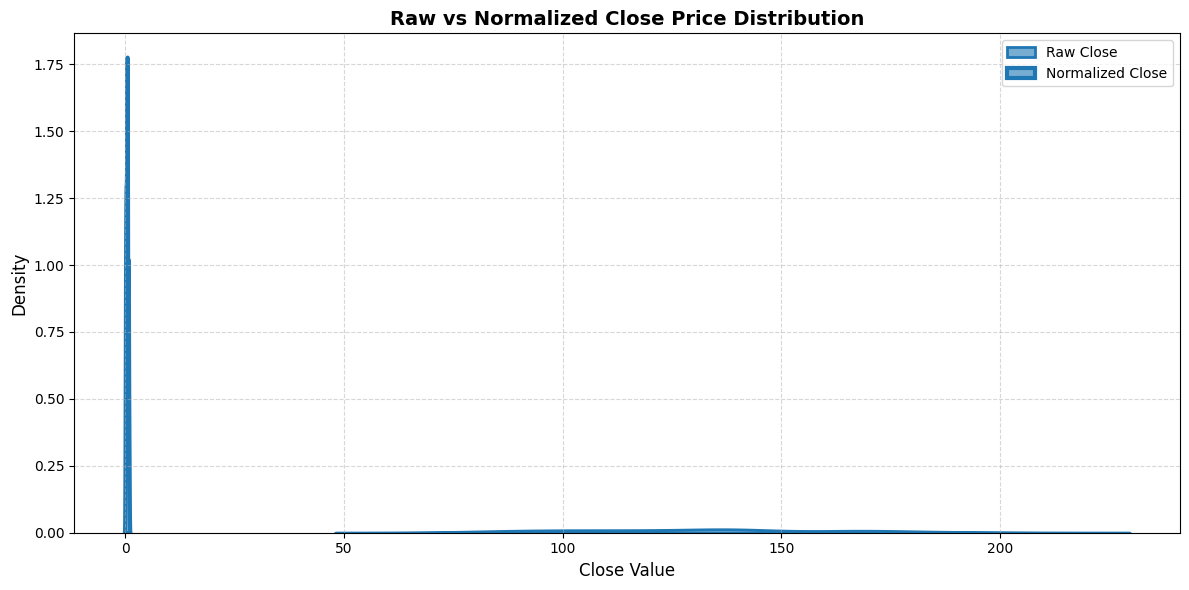

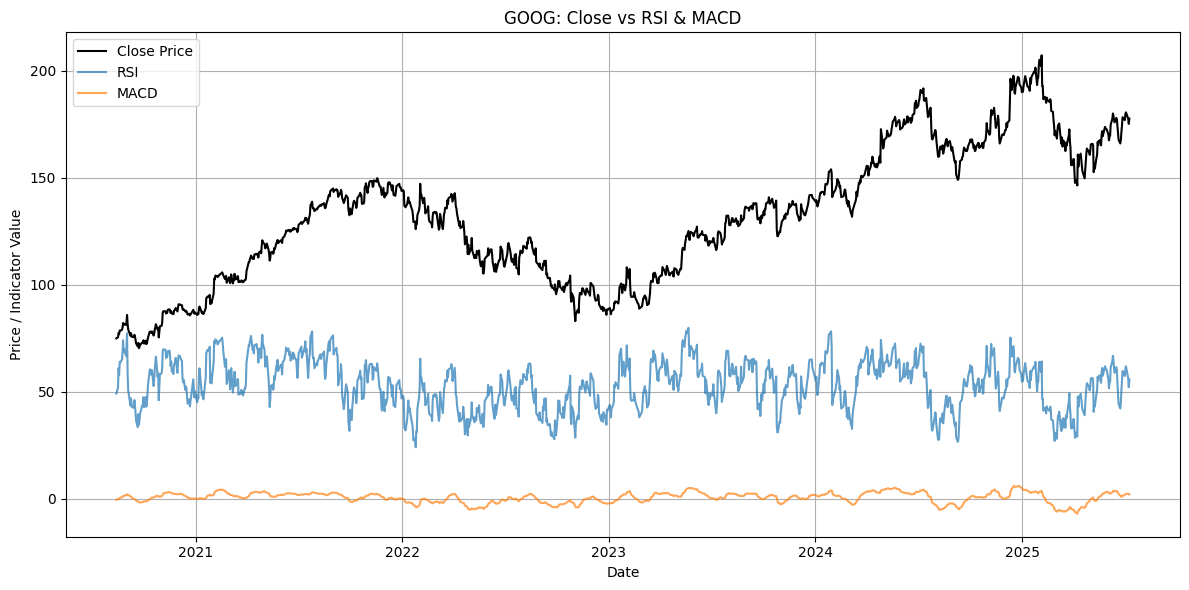

In [10]:
# b. 📈 Improved KDE Plot: Normalized vs Raw Close Price Distribution
plt.figure(figsize=(12, 6))  # Slightly larger figure for better readability

# Raw Close - Blue and bold
sns.kdeplot(df['Close'].dropna(), label='Raw Close', fill=True, color='royalblue', linewidth=2, alpha=0.6)

# Normalized Close - Orange and bold
sns.kdeplot(df_scaled['Close'].dropna(), label='Normalized Close', fill=True, color='darkorange', linewidth=3, alpha=0.6)

plt.title("Raw vs Normalized Close Price Distribution", fontsize=14, weight='bold')
plt.xlabel("Close Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='black')
plt.plot(df.index, df['RSI'], label='RSI', alpha=0.7)
plt.plot(df.index, df['MACD'], label='MACD', alpha=0.7)
plt.title(f"{df['Ticker'].iloc[0]}: Close vs RSI & MACD")  # Dynamically show ticker
plt.xlabel("Date")
plt.ylabel("Price / Indicator Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import gym
from gym import spaces


In [14]:
class PortfolioEnv(gym.Env):
    def __init__(self, df, window_size=30, initial_capital=1e6):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.price_col = 'Close'  # Can be adjusted for multi-asset later
        self.features = df.columns.drop(['Ticker'])
        self.window_size = window_size
        self.initial_capital = initial_capital
        self.current_step = 0

        self.action_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(window_size, len(self.features)), dtype=np.float32
        )

    def reset(self):
        self.current_step = 0
        self.cash = self.initial_capital
        self.asset = 0
        return self._get_obs()

    def _get_obs(self):
        end = self.current_step + self.window_size
        return self.df.loc[self.current_step:end-1, self.features].values

    def step(self, action):
        current_price = self.df.loc[self.current_step + self.window_size - 1, self.price_col]
        invest_frac = action[0]
        total_value = self.cash + self.asset * current_price

        self.asset = (invest_frac * total_value) / current_price
        self.cash = total_value * (1 - invest_frac)

        self.current_step += 1
        done = self.current_step + self.window_size >= len(self.df)

        next_price = self.df.loc[self.current_step + self.window_size - 1, self.price_col]
        new_value = self.cash + self.asset * next_price
        reward = (new_value - total_value) / total_value

        return self._get_obs(), reward, done, {}


In [15]:
env = PortfolioEnv(train_df)
obs = env.reset()
print("Observation shape:", obs.shape)


Observation shape: (30, 10)


In [17]:
pip install stable-baselines3[extra]


  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 3.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.0/821.0 MB 12.1 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 13.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 12.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 11.3 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 1

In [19]:
!pip install shimmy


In [20]:
from stable_baselines3 import PPO

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100_000)
model.save("ppo_portfolio")


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/tharun3086/soc_2025/venv/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/tharun3086/soc_2025/venv/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/home/tharun3086/soc_2025/venv/lib/pyth

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 831      |
|    ep_rew_mean     | 2.59     |
| time/              |          |
|    fps             | 426      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 831          |
|    ep_rew_mean          | 2.53         |
| time/                   |              |
|    fps                  | 231          |
|    iterations           | 2            |
|    time_elapsed         | 17           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0027559306 |
|    clip_fraction        | 0.0165       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | -8.79        |
|    learning_r

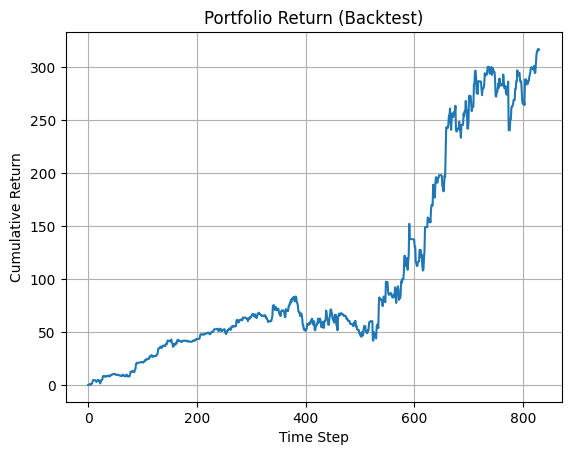

In [21]:
obs = env.reset()
done = False
returns = []
while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    returns.append(reward)

cumulative = np.cumprod([1 + r for r in returns]) - 1
plt.plot(cumulative)
plt.title("Portfolio Return (Backtest)")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()
